## Learning diffusivity (m) to solution (u) map for Poisson problem (Implementation 1)

Data is located in `../data` directory, and key data of our interest is in `Poisson_samples.npz` file. We would also need the mesh data in files with names `Poisson_m_mesh` and `Poisson_u_mesh` for plotting.

> Implementation is from [base_example_to_try_different_implementations/from_deeponet-fno.ipynb](../../../base_example_to_try_different_implementations/from_deeponet-fno.ipynb) which is based on [deeponet-fno/src/darcy_triangular_notch
/deeponet](https://github.com/lu-group/deeponet-fno/tree/main/src/darcy_triangular_notch/deeponet) of [deeponet-fno](https://github.com/lu-group/deeponet-fno/tree/main) library. It uses `tensorflow.compat.v1`.

### Results
Below shows the neural operator prediction for different samples of test input. 

<p align="center"> <img src="Results_implement1/neural_operator_prediction_comparison.png" width="800"> </p>

In [1]:
import sys
import os
import time

# os.environ['CUDA_VISIBLE_DEVICES']='-1'
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

import numpy as np
import scipy

import dolfin as dl

util_path = "../../../utilities/"
sys.path.append(util_path)
from plotUtilities import field_plot_fenics
from dataMethods import DataProcessorTF 
from tf_savedata import SaveData
from tf_fnn import FNN

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# set seed
seed = 0
np.random.seed(seed)
tf.set_random_seed(seed)

2024-11-10 23:46:40.976641: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-10 23:46:40.996293: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-10 23:46:41.001560: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-10 23:46:41.015290: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
data_folder = '../data/'
current_directory = os.getcwd()  
results_dir = current_directory + '/Results_implement1/'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

## Load data

In [3]:
num_train = 1900
num_test = 100

num_inp_fn_points = 2601 # number of grid points for the input function
num_out_fn_points = 2601 # number of evaluations points for the output function
num_Y_components = 2 # displacement field in 2D
num_tr_outputs = 100 # number of outputs from the trunk network before they are multiplied
num_br_outputs = num_Y_components * num_tr_outputs # 100 for u1 and 100 for u2
out_coordinate_dimension = 2 # domain for output function is 2D

#branch net
layer_B = [num_inp_fn_points, 128, 128, num_br_outputs]
#trunk net
layer_T = [2, 128, 128, num_tr_outputs]

# training hyperparameters
batch_size = 100
epochs = 1000
lr = 1.0e-3

data_prefix = 'LinearElasticity'
data = DataProcessorTF(batch_size, data_folder + data_prefix + '_samples.npz', num_train, num_test, num_inp_fn_points, num_out_fn_points, num_Y_components)

train_data = {'X_train': data.X_train, 'X_trunk': data.X_trunk, 'Y_train': data.Y_train}
test_data = {'X_train': data.X_test, 'X_trunk': data.X_trunk, 'Y_train': data.Y_test}

print('X_train:',data.X_train.shape)
print('Y_train:',data.Y_train.shape)
print('X_test:',data.X_test.shape)
print('Y_test:',data.Y_test.shape)
print('X_trunk:',data.X_trunk.shape)

X_train: (1900, 1, 2601)
Y_train: (1900, 5202, 1)
X_test: (100, 1, 2601)
Y_test: (100, 5202, 1)
X_trunk: (2601, 2)


## Create model and train the network

In [4]:
X_train, X_trunk_train, Y_train, X_trunk_min, X_trunk_max = data.minibatch()
X_trunk_pos = tf.constant(X_trunk_train, dtype=tf.float32)
X_trunk_tf = tf.tile(X_trunk_pos[None, :, :], [batch_size, 1, 1]) #[bs, x_num, x_dim]

X_ph = tf.placeholder(shape=[None, 1, num_inp_fn_points], dtype=tf.float32) #[bs, f_dim]
Y_ph = tf.placeholder(shape=[None, num_out_fn_points*num_Y_components, 1], dtype=tf.float32) #[bs, x_num*y_components, 1]

learning_rate = tf.placeholder(tf.float32, shape=[])

fnn_model = FNN()

# Branch net
W_B, b_B = fnn_model.hyper_initial(layer_B)
u_B = fnn_model.fnn_B(W_B, b_B, X_ph)
u_B = tf.tile(u_B, [1, num_out_fn_points, 1])   
print('u_B shape:', u_B.shape)

#Trunk net
W_T, b_T = fnn_model.hyper_initial(layer_T)
u_T = fnn_model.fnn_T(W_T, b_T, X_trunk_tf, X_trunk_min, X_trunk_max)
# u_T = tf.tile(u_T, [1, 1, 2])
print('u_T shape:', u_T.shape)

#inner product
Y_pred = [u_B[:, :, :num_tr_outputs]*u_T, u_B[:, :, num_tr_outputs:]*u_T]
Y_pred = tf.stack(Y_pred, axis=-1)
Y_pred = tf.reduce_sum(Y_pred, axis=2)
Y_pred = tf.reshape(Y_pred, [-1, num_out_fn_points*num_Y_components, 1], name='F')
print('Y_pred.shape:', Y_pred.shape)

u_B shape: (?, 2601, 200)
u_T shape: (100, 2601, 100)
Y_pred.shape: (100, 5202, 1)


In [5]:
# loss function 
loss = tf.reduce_mean(tf.square(Y_ph - Y_pred))
train = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)
saver = tf.train.Saver()
sess = tf.Session()  
sess.run(tf.global_variables_initializer())

# verify the error calculation
X_train, X_trunk_train, Y_train, _, _ = data.minibatch()
train_dict={X_ph: X_train, Y_ph: Y_train, learning_rate: lr}
loss_ = sess.run(loss, feed_dict=train_dict)

Y_train_ = sess.run(Y_pred, feed_dict={X_ph: X_train})
err = np.mean(np.square(Y_train_ - Y_train))

print('='*30)
print('Train Loss (l2 squared): {:.3e}, Train Loss (l2 squared): {:.3e}'.format(loss_, err))
print('='*30)


I0000 00:00:1731307607.607682  411992 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731307607.610062  411992 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731307607.610320  411992 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731307607.614498  411992 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Train Loss (l2 squared): 1.216e+00, Train Loss (l2 squared): 1.216e+00


In [6]:
# begin training
n = 0
start_time = time.perf_counter()

train_loss = np.zeros((epochs+1, 1))
test_loss = np.zeros((epochs+1, 1))    

loss_print_freq = 100

while n <= epochs:

    if n < 1000:
        lr = 0.001
    elif n < 5000:
        lr = 0.0005
    else:
        lr = 0.0001
            
    start_time = time.perf_counter()
    
    # network training
    X_train, X_trunk_train, Y_train, _, _ = data.minibatch()
    train_dict={X_ph: X_train, Y_ph: Y_train, learning_rate: lr}
    loss_, _ = sess.run([loss, train], feed_dict=train_dict)
    
    # network testing
    X_test, X_trunk_test, Y_test = data.testbatch(batch_size)
    Y_test_ = sess.run(Y_pred, feed_dict={X_ph: X_test})
    # Y_test = data.decoder_Y(Y_test)
    # Y_test_ = data.decoder_Y(Y_test_)
    
    # testing error
    err = np.mean(np.square(Y_test_ - Y_test))
    
    end_time = time.perf_counter()

    epoch_time = end_time - start_time

    if n % loss_print_freq == 0:
        print('='*30)
        print('Epoch: {:5d}, Train Loss (l2 squared): {:.3e}, Test Loss (l2 squared): {:.3e}, Time (sec): {:.3f}'.format(n, loss_, err, epoch_time))
        print('='*30)

    train_loss[n,0] = loss_
    test_loss[n,0] = err
    n += 1

Epoch:     0, Train Loss (l2 squared): 1.011e+00, Test Loss (l2 squared): 1.125e+00, Time (sec): 0.384
Epoch:   100, Train Loss (l2 squared): 5.701e-01, Test Loss (l2 squared): 3.283e-01, Time (sec): 0.073
Epoch:   200, Train Loss (l2 squared): 3.740e-01, Test Loss (l2 squared): 2.605e-01, Time (sec): 0.063
Epoch:   300, Train Loss (l2 squared): 1.714e-01, Test Loss (l2 squared): 2.222e-01, Time (sec): 0.075
Epoch:   400, Train Loss (l2 squared): 2.034e-01, Test Loss (l2 squared): 2.316e-01, Time (sec): 0.076
Epoch:   500, Train Loss (l2 squared): 2.425e-01, Test Loss (l2 squared): 2.026e-01, Time (sec): 0.074
Epoch:   600, Train Loss (l2 squared): 2.451e-01, Test Loss (l2 squared): 2.117e-01, Time (sec): 0.077
Epoch:   700, Train Loss (l2 squared): 1.859e-01, Test Loss (l2 squared): 2.077e-01, Time (sec): 0.076
Epoch:   800, Train Loss (l2 squared): 2.060e-01, Test Loss (l2 squared): 2.378e-01, Time (sec): 0.071
Epoch:   900, Train Loss (l2 squared): 1.759e-01, Test Loss (l2 squared):

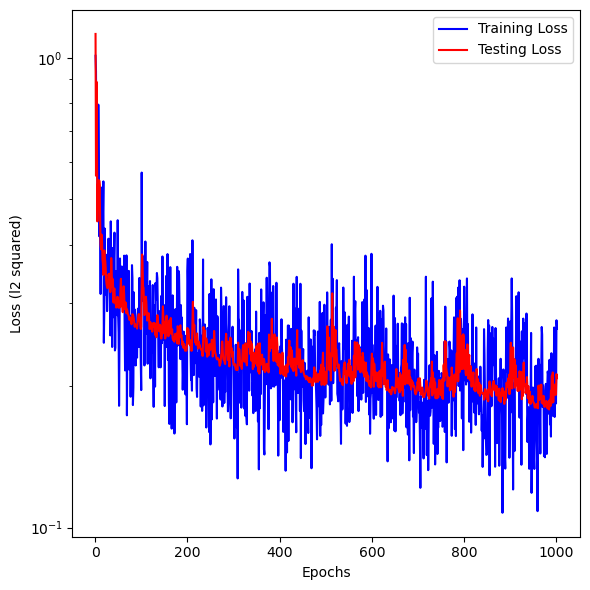

In [7]:
## Plotting the loss history
num_epoch = train_loss.shape[0]
x = np.linspace(1, num_epoch, num_epoch)
fig = plt.figure(constrained_layout=False, figsize=(6, 6))
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0])
ax.plot(x, train_loss[:,0], color='blue', label='Training Loss')
ax.plot(x, test_loss[:,0], color='red', label='Testing Loss')
ax.set_yscale('log')
ax.set_ylabel('Loss (l2 squared)')
ax.set_xlabel('Epochs')
ax.legend(loc='best')
fig.tight_layout()
fig.savefig(results_dir+'loss_his.png',  bbox_inches='tight')
plt.show()

In [9]:
save_models_to = results_dir +"model/"
if not os.path.exists(save_models_to):
    os.makedirs(save_models_to)      

saver.save(sess, save_models_to+'Model')

np.savetxt(results_dir+'/train_loss.txt', train_loss)
np.savetxt(results_dir+'/test_loss.txt', test_loss)

data_save = SaveData()
data_save.save(sess, X_trunk_pos, fnn_model, \
             W_T, b_T, W_B, b_B, \
             X_trunk_min, X_trunk_max, \
             X_ph, Y_ph, \
             data, num_test, \
             num_tr_outputs, num_Y_components, \
             results_dir, data_prefix)

error (l2 squared): 0.208


## Test and plot the output of network

In [10]:
X_test, X_trunk_test, Y_test = data.testbatch(batch_size)
Y_test_pred = sess.run(Y_pred, feed_dict={X_ph: X_test})

error = np.mean(np.linalg.norm(Y_test_pred - Y_test, 2, axis=1)/np.linalg.norm(Y_test, 2, axis=1))

print('test_out shape: {}, test_pred shape: {}'.format(Y_test.shape, Y_test_pred.shape))

print('Num tests: {:5d}, Mean Loss (rel l2): {:.3e}, Std Loss (rel l2): {:.3e}'.format(num_test, np.mean(error), np.std(error)))

test_out shape: (100, 5202, 1), test_pred shape: (100, 5202, 1)
Num tests:   100, Mean Loss (rel l2): 4.965e-01, Std Loss (rel l2): 0.000e+00


In [11]:
def get_FE_space(mesh_file = data_folder + 'LinearElasticity_u_mesh.xdmf', is_vector = False):
    mesh = dl.Mesh()
    with dl.XDMFFile(mesh_file) as infile:
        infile.read(mesh)
    if is_vector:
        V = dl.VectorFunctionSpace(mesh, "Lagrange", 1)
    else:
        V = dl.FunctionSpace(mesh, "Lagrange", 1)
    return V

i_plot =    75, error (rel l2): 1.207e-02
i_plot =    54, error (rel l2): 6.181e-02
i_plot =    74, error (rel l2): 5.084e-02
i_plot =    56, error (rel l2): 5.999e-03
i_plot =    43, error (rel l2): 1.022e-02
i_plot =    51, error (rel l2): 9.353e-03
i_plot =    82, error (rel l2): 8.623e-03
i_plot =    89, error (rel l2): 1.022e-02
i_plot =    50, error (rel l2): 9.455e-03
i_plot =    10, error (rel l2): 9.667e-03
i_plot =    11, error (rel l2): 5.319e-03
i_plot =    76, error (rel l2): 1.697e-02
i_plot =     7, error (rel l2): 3.329e-02
i_plot =    18, error (rel l2): 1.397e-02
i_plot =    21, error (rel l2): 1.640e-02
i_plot =     3, error (rel l2): 1.335e-02


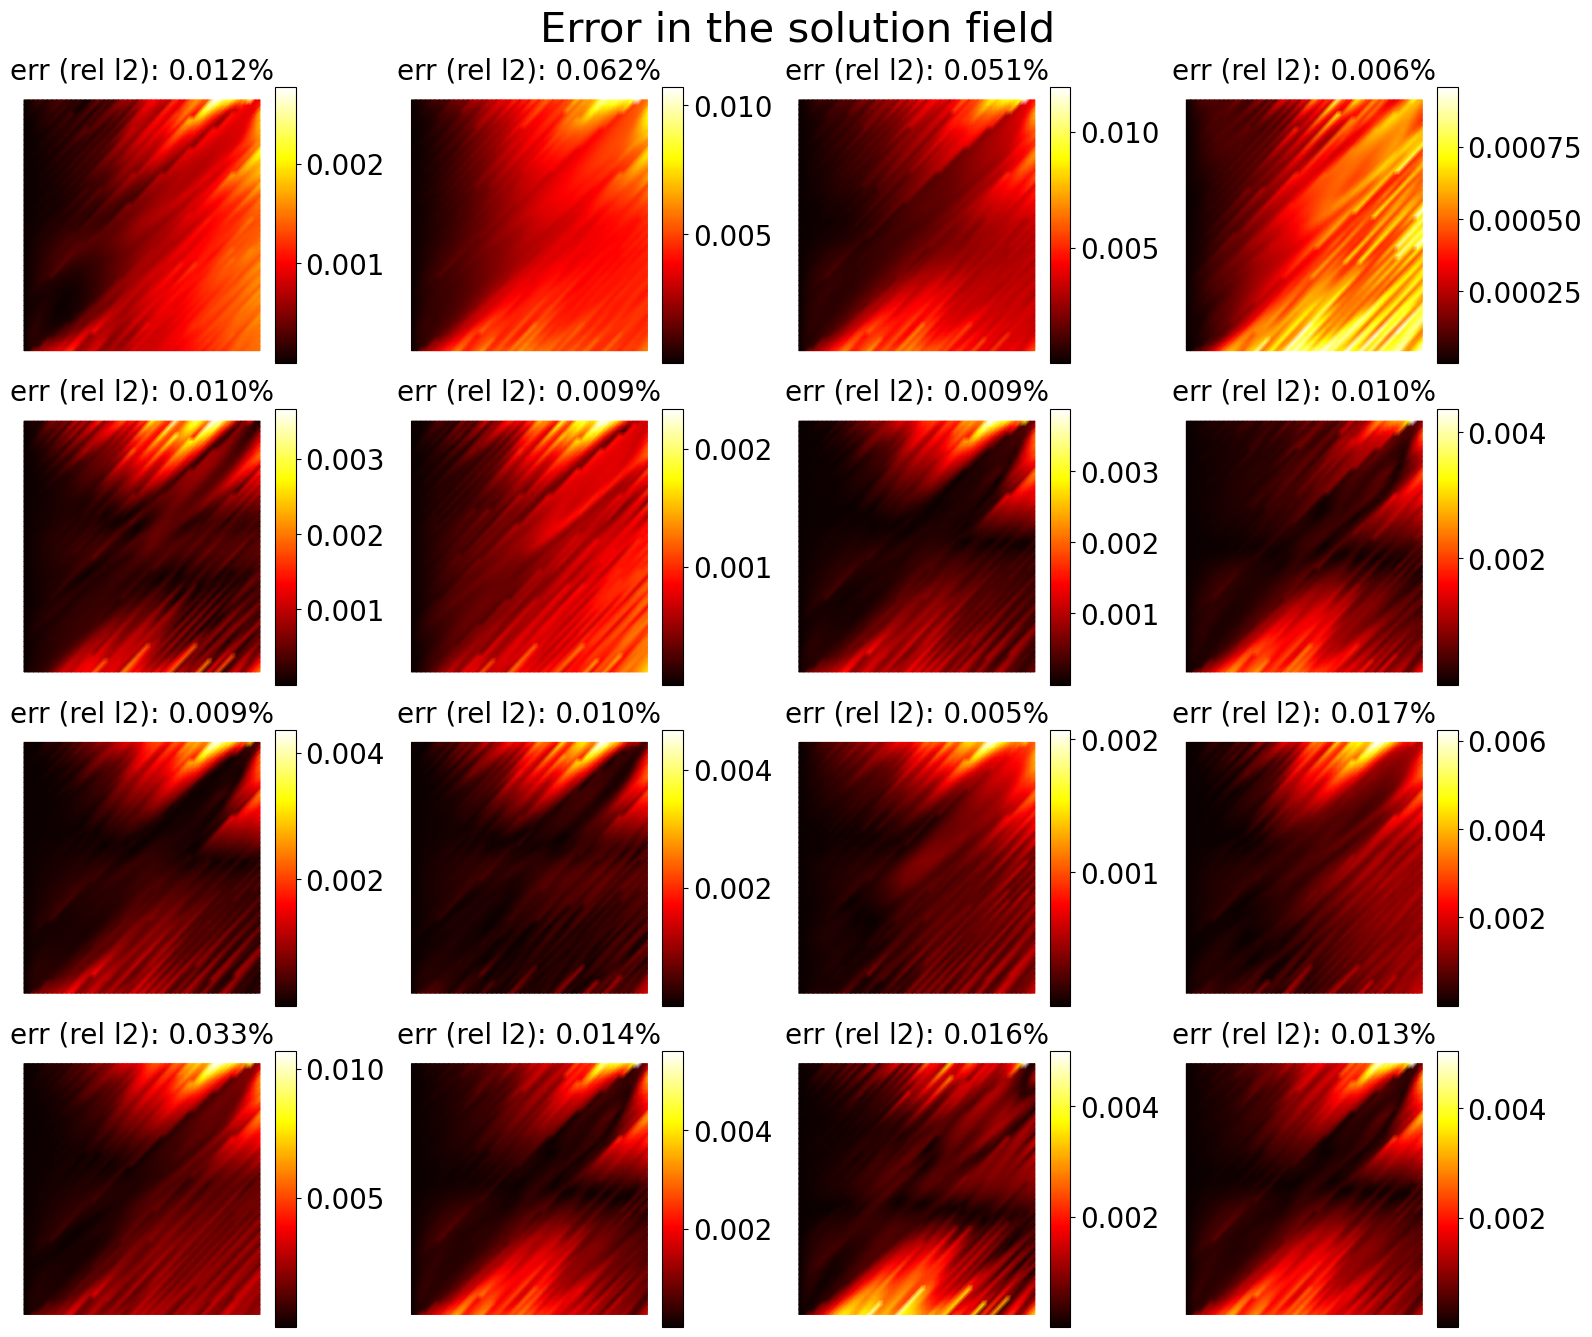

In [12]:
rows, cols = 4, 4
fs = 20
fig, axs = plt.subplots(rows, cols, figsize=(16, 13))

decode = True

Vu = get_FE_space(data_folder + data_prefix + '_u_mesh.xdmf', is_vector=True)
Vm = get_FE_space(data_folder + data_prefix + '_m_mesh.xdmf')

Y_spatial_points = data.X_trunk

# randomly choose rows number of samples
i_choices = np.random.choice(num_test, rows*cols, replace=False)

for i in range(rows):
    for j in range(cols):
        i_plot = i_choices[i*cols + j]

        i_pred = Y_test_pred[i_plot]
        i_truth = Y_test[i_plot]
        if decode:
            i_pred = data.decoder_Y(i_pred).flatten()
            i_truth = data.decoder_Y(i_truth).flatten()
            
        i_diff = i_pred - i_truth
        i_diff_norm = np.linalg.norm(i_diff) / np.linalg.norm(i_truth)
        print('i_plot = {:5d}, error (rel l2): {:.3e}'.format(i_plot, i_diff_norm))

        nodes = Y_spatial_points

        cbar = field_plot_fenics(axs[i,j], i_diff, Vu, cmap = 'hot')

        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='8%', pad=0.03)
        cax.tick_params(labelsize=fs)
        fig.colorbar(cbar, cax=cax, orientation='vertical')

        err_str = 'err (rel l2): {:.3f}%'.format(i_diff_norm)
        axs[i,j].set_title(err_str, fontsize=fs)

        axs[i,j].axis('off')

fig.tight_layout()
fig.suptitle('Error in the solution field', fontsize=1.5*fs, y=1.025)
fig.savefig(results_dir+'sample_error_plots.png',  bbox_inches='tight')
plt.show()


i_plot =    89, error (rel l2): 1.022e-02
i_plot =    57, error (rel l2): 1.377e-02
i_plot =    72, error (rel l2): 1.089e-02
i_plot =    64, error (rel l2): 7.644e-03


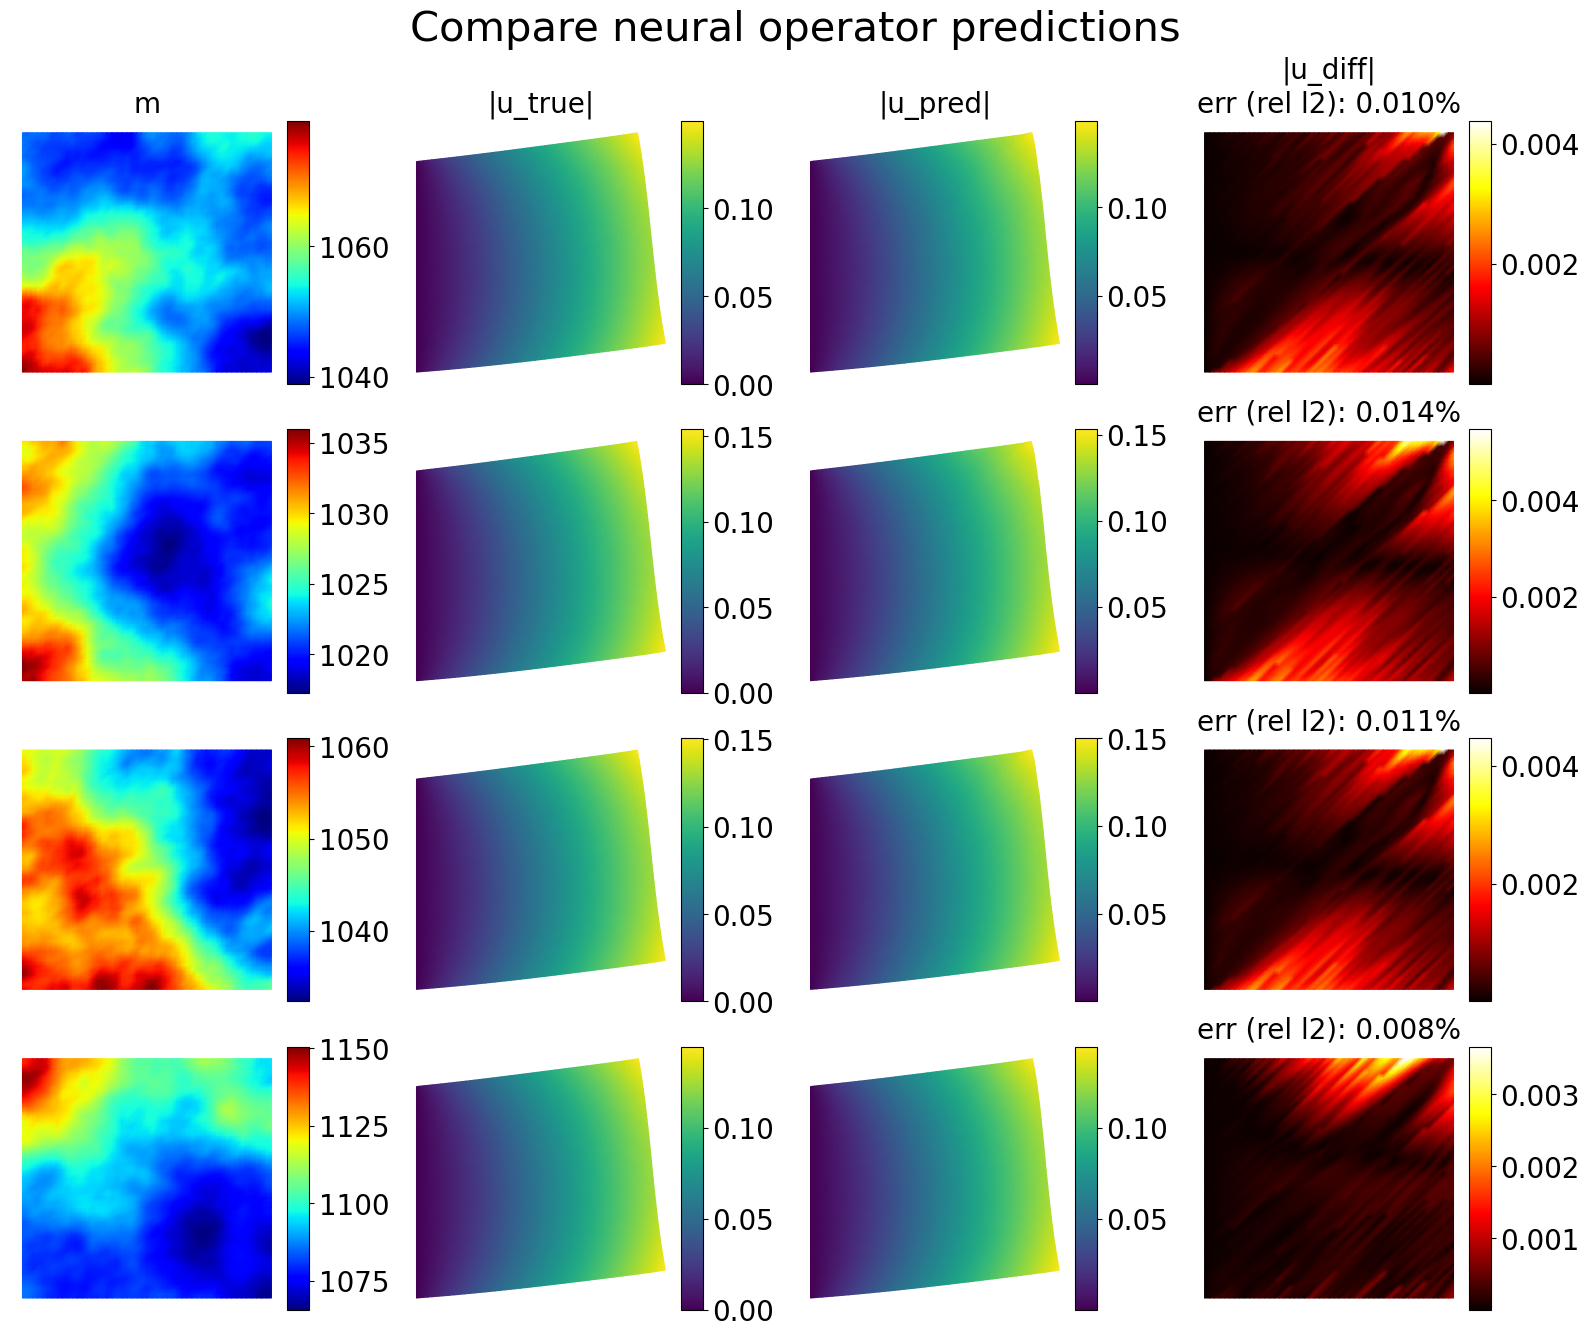

In [15]:
rows, cols = 4, 4
fs = 20
fig, axs = plt.subplots(rows, cols, figsize=(16, 13))

decode = True

Vu = get_FE_space(data_folder + 'LinearElasticity_u_mesh.xdmf', is_vector=True)
Vm = get_FE_space(data_folder + 'LinearElasticity_m_mesh.xdmf')

# row: m, u_true, u_pred, u_diff
u_tags = ['m', '|u_true|', '|u_pred|', '|u_diff|']
cmaps = ['jet', 'viridis', 'viridis', 'hot']
Vvec = [Vm, Vu, Vu, Vu]
Y_spatial_points = data.X_trunk # for this problem, nodes are same for m and u functions
X_spatial_points = Y_spatial_points

# randomly choose rows number of samples
i_choices = np.random.choice(num_test, rows, replace=False)

for i in range(rows):
    
    i_plot = i_choices[i]

    i_pred = Y_test_pred[i_plot]
    i_truth = Y_test[i_plot]
    i_m_test = data.X_test[i_plot]
    if decode:
        i_pred = data.decoder_Y(i_pred).flatten()
        i_truth = data.decoder_Y(i_truth).flatten()
        i_m_test = data.decoder_X(i_m_test).flatten()
            
    i_diff = i_pred - i_truth
    i_diff_norm = np.linalg.norm(i_diff) / np.linalg.norm(i_truth)
    print('i_plot = {:5d}, error (rel l2): {:.3e}'.format(i_plot, i_diff_norm))

    uvec = [i_m_test, i_truth, i_pred, i_diff]
    
    for j in range(cols):
        nodes = Y_spatial_points if j > 0 else X_spatial_points
        
        if j == 0:
            cbar = field_plot_fenics(axs[i,j], uvec[j], Vvec[j], cmap = cmaps
            [j])
        elif j == cols - 1:
            cbar = field_plot_fenics(axs[i,j], uvec[j].flatten(), Vvec[j], \
                                     cmap = cmaps[j], \
                                     add_displacement_to_nodes = False,\
                                     is_displacement = True)
        else:
            cbar = field_plot_fenics(axs[i,j], uvec[j].flatten(), Vvec[j], \
                                     cmap = cmaps[j], \
                                     add_displacement_to_nodes = True,\
                                     is_displacement = True)

        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='8%', pad=0.03)
        cax.tick_params(labelsize=fs)

        if j == 0 or j == cols - 1:
            # format cbar ticks
            kfmt = lambda x, pos: "{:g}".format(x)
            
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical', format = kfmt)
        else:
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical')

        if i == 0 and j < cols - 1:
            axs[i,j].set_title(u_tags[j], fontsize=fs)
        
        if j == cols - 1:
            err_str = 'err (rel l2): {:.3f}%'.format(i_diff_norm)
            if i == 0:
                err_str = u_tags[j] + '\n' + err_str
            axs[i,j].set_title(err_str, fontsize=fs)

        axs[i,j].axis('off')

fig.tight_layout()
fig.suptitle('Compare neural operator predictions', fontsize=1.5*fs, y=1.025)
fig.savefig(results_dir+'neural_operator_prediction_comparison.png',  bbox_inches='tight')
plt.show()
